In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

In [2]:
#read pickle file
#This data shows what happens when three SiPMs are placed under the Sr-90 source.

In [3]:
df = pd.read_pickle("Nov18SourceB2B.pkl")

In [4]:
#Converts milivolts to Photoelectrons

In [5]:
df.eval('ch1_P2P_smooth_PE = (1/6.327) *ch1_P2P_smooth', inplace=True)
df.eval('ch2_P2P_smooth_PE = (1/6.344) *ch2_P2P_smooth', inplace=True)
df.eval('ch3_P2P_smooth_PE = (1/1.452) *ch3_P2P_smooth', inplace=True)

47843 out of 223347 events were recorded when bottom most SiPM(SensL) hit above 6PE


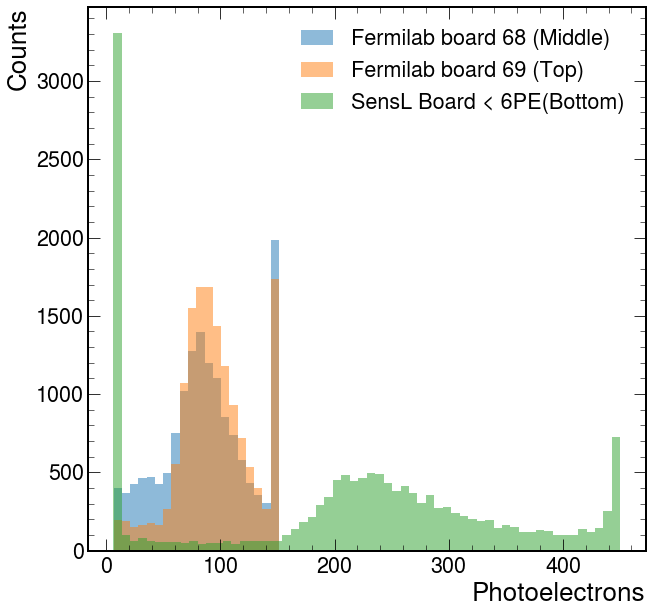

In [11]:
#Plotting while restricting data for events in which lowest SensL SiPM recieved a signal

#change limit for SensL here, decided to use 6PE
limit='6'

plt.hist(df.query('ch3_P2P_smooth_PE>%s'%(limit))['ch1_P2P_smooth_PE'], bins=20,label = 'Fermilab board 68 (Middle)',alpha = 0.5)
plt.hist(df.query('ch3_P2P_smooth_PE>%s'%(limit))['ch2_P2P_smooth_PE'], bins=20,label = 'Fermilab board 69 (Top)',alpha = 0.5)
plt.hist(df.query('ch3_P2P_smooth_PE>%s'%(limit))['ch3_P2P_smooth_PE'], bins=60,label = 'SensL Board < %sPE(Bottom)'%(limit),alpha = 0.5)


plt.legend()
plt.xlabel('Photoelectrons')
plt.ylabel('Counts')

print(len(df.query('ch3_P2P_smooth>%s'%limit)['ch1_P2P_smooth_PE']),'out of',len(df['ch3_P2P_smooth']), 'events were recorded when bottom most SiPM(SensL) hit above %sPE'%(limit))


In [12]:
#Calculates the time difference between to top and middle SiPM.

In [13]:
df.eval('time_diff = ch1_time_smooth - ch2_time_smooth', inplace=True)

In [14]:
#Calculates the signal strength

In [15]:
df.eval('signal_strength=(ch1_P2P_smooth_PE*ch2_P2P_smooth_PE)/((ch1_P2P_smooth_PE**2+ch2_P2P_smooth_PE**2)**(1/2))',inplace=True)

In [ ]:
#(Optional)Plots the signal strength

In [ ]:
plt.hist(df['signal_strength'],bins=80)

In [ ]:
#Plots the time difference under the restriction that the bottom most SiPM recevied a signal above the chosen limit

Text(0.5, 1.0, '\n Time Difference Between SiPM Boards\n')

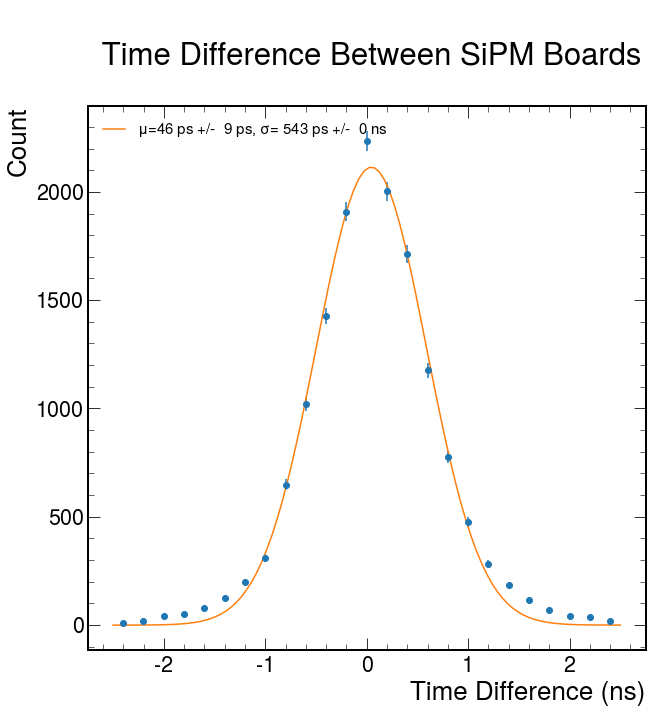

In [22]:
from scipy.optimize import curve_fit
import numpy as np

#Limit in Photoelectrons of bottom SiPM to have gotten was set to 6
limit=6

hist, bin_edges = np.histogram(df.query('ch3_P2P_smooth_PE>%s'%(limit))['time_diff'],bins=25,range=(-2.5,2.5))
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#amplitude, mean, sigma
p0 = [70.,2.,0.5]

coeff, var_matrix = curve_fit(gauss, bin_centers, hist, p0=p0)
hist_fit = gauss(np.linspace(-2.5, 2.5, 100), *coeff)
plt.errorbar(bin_centers, y=hist, yerr=np.sqrt(hist),fmt='o')
plt.plot(np.linspace(-2.5,2.5,100), hist_fit)


plt.xlabel("Time Difference (ns)")
plt.ylabel("Count")
plt.legend(['$\mu$=%2.0f ps +/- %2.0f ps, $\sigma$= %2.0f ps +/- %2.0f ns'%(coeff[1]*1000,(np.sqrt(var_matrix[1][1]))*1000,coeff[2]*1000,np.sqrt(var_matrix[2][2]))],loc=2,prop={'size': 15})


plt.title('\n Time Difference Between SiPM Boards\n')

#plt.savefig('Nov18SourceTimeDiff.png')

In [ ]:
#Plots Signal Strength with time resolution, you might get a warning for some reason

/home/arratialab/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 1, 'Time resolution [ps]')

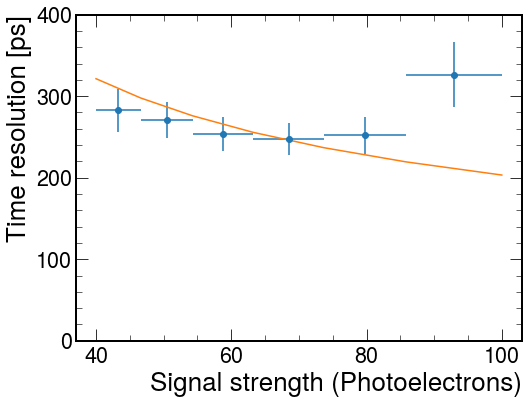

In [27]:
sigma_t  = np.array([])
sigma_t_error = np.array([])
centers = np.array([])
xerrors = np.array([])


photobins = np.geomspace(40,100,7)
#print(photobins)

for i in range(len(photobins)-1):
    edges = (photobins[i],photobins[i+1])
        
    hist, bin_edges = np.histogram(df.query('signal_strength>%2.2f and signal_strength<%2.2f'%(edges[0],edges[1]))['time_diff'],bins=10,range=(-2,2))

    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [1,0,.5]
    coeff, var_matrix = curve_fit(gauss, bin_centers, hist, p0=p0)
                            #(start,end,line quality keep at 100)
    hist_fit = gauss(np.linspace(-2, 2, 100), *coeff)

    sigma_t = np.append(sigma_t, 1000.0*abs(coeff[2])/np.sqrt(2)) #divide by sqrt(2) to transform to single detector resolution?
    sigma_t_error = np.append(sigma_t_error, 1000.0*np.sqrt(var_matrix[2][2])/np.sqrt(2))
    centers = np.append(centers, (edges[0]+edges[1])/2.0)
    xerrors = np.append(xerrors, (edges[1]-edges[0])/2.0)



def resolution(x, *p):
    A, l = p
    return A/np.sqrt(x)
    
fig = plt.figure(figsize=(8,6))
plt.errorbar(centers,y=sigma_t,xerr=xerrors,yerr=sigma_t_error,fmt='o')
coeff, var_matrix = curve_fit(resolution, centers, sigma_t, p0=[100,5],sigma=sigma_t_error)

plt.plot(photobins, resolution(photobins, *coeff),label='A/$\sqrt(E)$ fit')


plt.ylim([0,400])
plt.xlabel('Signal strength (Photoelectrons)')
plt.ylabel('Time resolution [ps]')

#plt.savefig('Nov18Sourcetimestrength2.png')